In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import read, write
from math import ceil
import os
from IPython.display import Audio

In [2]:
FRAME_SIZE = 1024
curr_dir = os.getcwd() + '/' + 'AudioMNIST/data'
# 100e4 for AudioMNIST data set
# for android tablet
THRESHOLD = 200e6 # must be tuned
FRAME_SETBACK = 10 # number of frames to prepend before first frame with significant energy content above the threshold

NUM_ROWS = int((1024 / 2) + 1)
NUM_COLS = 48 # total number of frames to leave in trimmed audio data

#### Introduction

Voice Activity Detection is important for consistently extracting data for speaker recognition. Many Automatic Speaker Recognition (ASR) models are created with the intent of only being applied on audio segments with speech in them. Currently in the scope of ECE 420, AudioMNIST provided consistent audio segments that have been trimmed to only focus on the portions where the speakers are actually voicing a digit 0-9. The trimming done for this dataset was manual, but for a real-time task, we must figure out how to get an Android tablet to automatically recognize when the speaker is talking in an audio segment and solely extract data from that portion of the audio. VAD is an interesting problem with complex manners of tackling the issue, but for the purposes of ECE420, we will use the simple pitch detection from lab to aid in extracting the spoken segements from audio data. 

Once thing to note with how the number of frames are being determined. For simple pitch detection, we simply create a constant FRAME_SIZE (preferably a power of 2 so that the frame size matches the frame size used for the STFT), and slide this window every FRAME_SIZE samples. Typically for the STFT though, 50% overlap is employed in order to deal with spectral leakage. This means that we must also employ 50% overlap when performing simple pitch detection so that the number of frames in the energy spectrum from the pitch detection match the number of frames from the STFT. By doing so, we are able to easily deduce which frames need to be dropped from the STFT that do not contain voiced data. 

In [3]:
def ece420ProcessFrame(frame, threshold = THRESHOLD):
    isVoiced = 0

    #### YOUR CODE HERE ####
    sum = 0
    for n in range(len(frame)):
        sum += abs(frame[n])**2

    if sum > threshold:
        isVoiced = 1

    return isVoiced

def soundDataToFloat(SD):
    "Converts integer representation back into librosa-friendly floats, given a numpy array SD"
    return np.array([ np.float32(s/32768.0) for s in SD])

def soundDataToInt16(SD):
    return np.array( [np.int16(s*32768.0) for s in SD] )

def frameVoiced(frame, threshold):
    isVoiced = False
    sum = 0
    for i in range(len(frame)):
        sum += abs(frame[i])**2

    if (sum > threshold):
        isVoiced = 1
    
    return isVoiced

def trimSamples(samples, frameSize, nfft, noverlap, threshold, frame_setback):
    num_samples = len(samples)
    if (noverlap < 0):
        noverlap = int(nfft/2)

    step = nfft - noverlap

    numFrames = ceil(num_samples / step)

    while ((numFrames - 1)*step + (nfft - 1) >= num_samples):
        numFrames -= 1

    first_frame = 0
    for i in range(numFrames):
        if frameVoiced(soundDataToInt16(samples[i*step:i*step + nfft]), threshold=threshold):
            first_frame = i
            break
    
    first_frame -= frame_setback
    if first_frame < 0:
        first_frame = 0
    last_frame = first_frame + frameSize
    num_trimmed_samples = ((last_frame - 1)*step + nfft) - (first_frame*step)
    trimmed_samples = np.zeros(num_trimmed_samples)

    for i in range(num_trimmed_samples):
        if (first_frame*step + i >= len(samples)):
            break
        trimmed_samples[i] = samples[first_frame*step + i]

    return trimmed_samples

len of data: 255360
Sampling rate of: 48000
Shape of STFT: (513, 497)
Number of Energy Spectrum Frames: 497
Len f: 513
Len t_stft: 497


/tmp/ipykernel_12940/2465922143.py:47: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(t, framesVoiced)


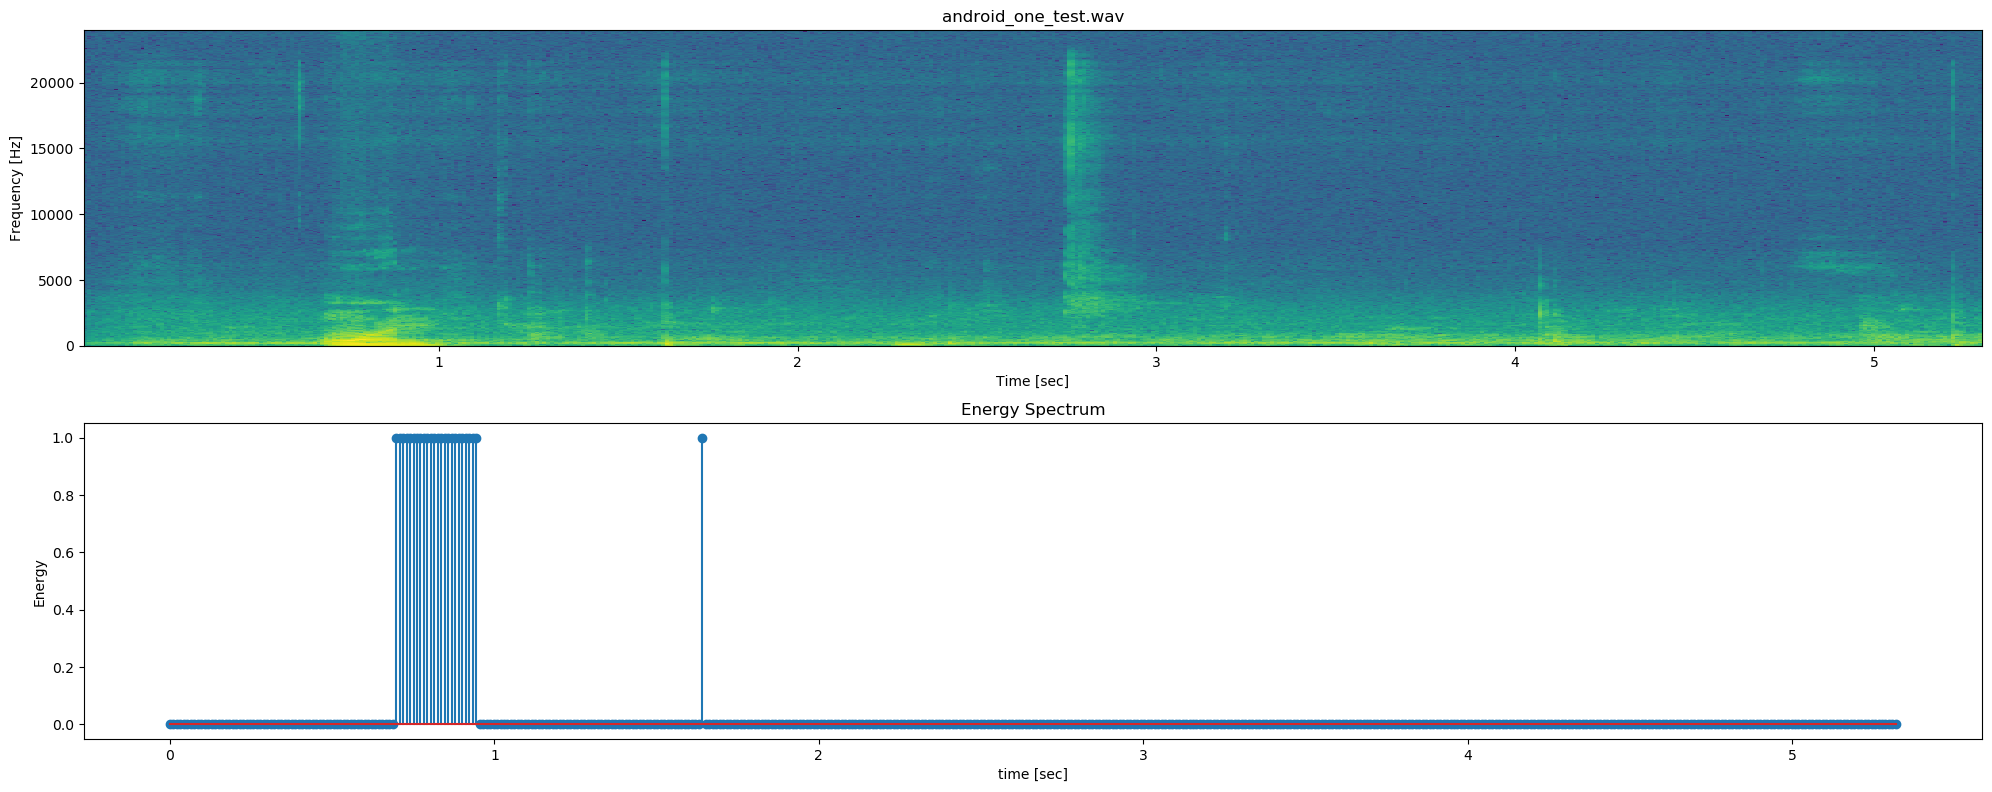

In [4]:
# song_file = '/01/0_01_0.wav'
# song_file = '/30/4_30_0.wav'
song_file = 'android_one_test.wav'
# Fs, data = read(curr_dir + song_file)
Fs, data = read(song_file)
num_samples = len(data)
print("len of data: {}".format(num_samples))

noverlap = int(FRAME_SIZE / 2)
step = FRAME_SIZE - noverlap
numFrames = ceil(num_samples / step)
while ((numFrames - 1)*step + (FRAME_SIZE - 1) >= num_samples):
    numFrames -= 1

# numFrames = int(len(data) / FRAME_SIZE)
framesVoiced = np.zeros(numFrames)
t = np.linspace(0, len(data)/Fs, numFrames)

for i in range(numFrames):
    frame = data[i * step : (i + 1) * step]
    framesVoiced[i] = ece420ProcessFrame(frame.astype(float))

print("Sampling rate of: {}".format(Fs))

# conducting a STFT of the data with the same frame size to show a comparision of the visualized sound and its energy spectrum
f, t_stft, result = signal.stft(data, fs=Fs, window='hann', nperseg=FRAME_SIZE, nfft=FRAME_SIZE, noverlap=None, detrend=False, return_onesided=True, boundary=None, padded=False, axis=-1, scaling='psd')
result = 20*np.log10(np.abs(result))

print("Shape of STFT: {}".format(result.shape))
print("Number of Energy Spectrum Frames: {}".format(numFrames))
print("Len f: {}".format(len(f)))
print("Len t_stft: {}".format(len(t_stft)))

fig = plt.figure(figsize=(20,8))
plt.subplot(211)
plt.pcolormesh(t_stft, f, result)
plt.title(song_file)
plt.axis('tight')
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
# plt.colorbar(format="%+2.f dB") # uncomment to interpret dB content, but leave out for side by side comparison 

plt.subplot(212)
plt.stem(t, framesVoiced)
plt.title("Energy Spectrum")
plt.xlabel("time [sec]")
plt.ylabel("Energy")

fig.tight_layout(pad=1.0)

In [5]:
# Recording of the sound
Audio(data, rate=Fs)

THRESHOLD is a tunable parameter that was set to 200e7 in lab but is instead 100e4 for the AudioMNIST dataset. Now that we have used our simple pitch detection to recognize which frames are voiced, we can attempt to do some trimming to get only the voiced segment.

65


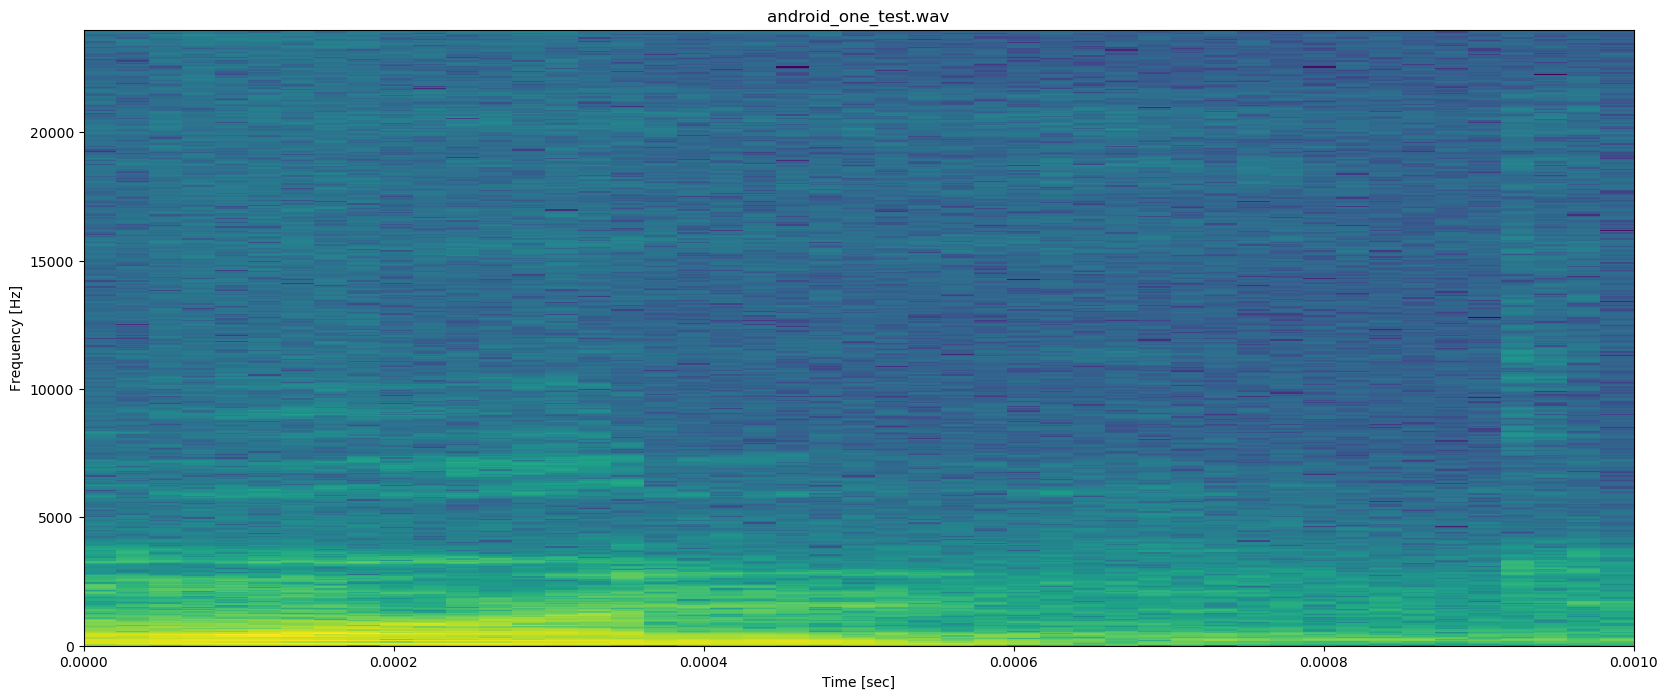

In [6]:
first_frame = np.argwhere(framesVoiced > 0)[0,0]
print(first_frame)
last_frame = (first_frame + NUM_COLS) if ((first_frame + NUM_COLS) < result.shape[1]) else result.shape[1]-1
# altering the STFT
segmented_result = np.zeros((NUM_ROWS, NUM_COLS))
for row in range(NUM_ROWS):
    for col in range(NUM_COLS):
        curr_frame = first_frame + col
        if curr_frame >= result.shape[1]:
            break
        segmented_result[row,col] = result[row, curr_frame]

# altering the data
segmented_data = data[first_frame*step:last_frame*step]

t_stft = np.linspace(0, NUM_COLS / Fs, NUM_COLS)
plt.figure(figsize=(20,8))
plt.pcolormesh(t_stft, f, segmented_result)
plt.title(song_file)
plt.axis('tight')
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
Audio(segmented_data, rate=Fs)

Typically the most energy is found in words which employ a lower '-duh' frequency sound. This comes from letters such as D and B. Listening to the trimmed audio carefully, it is clear that the speaker pronounces the letter Z with a '-duh' sound which explains why that was the first frame where energy was detected. There is still some valuable data from the frames before as can be seen in the STFT spectrum so we will just constantly collect these few frames. 

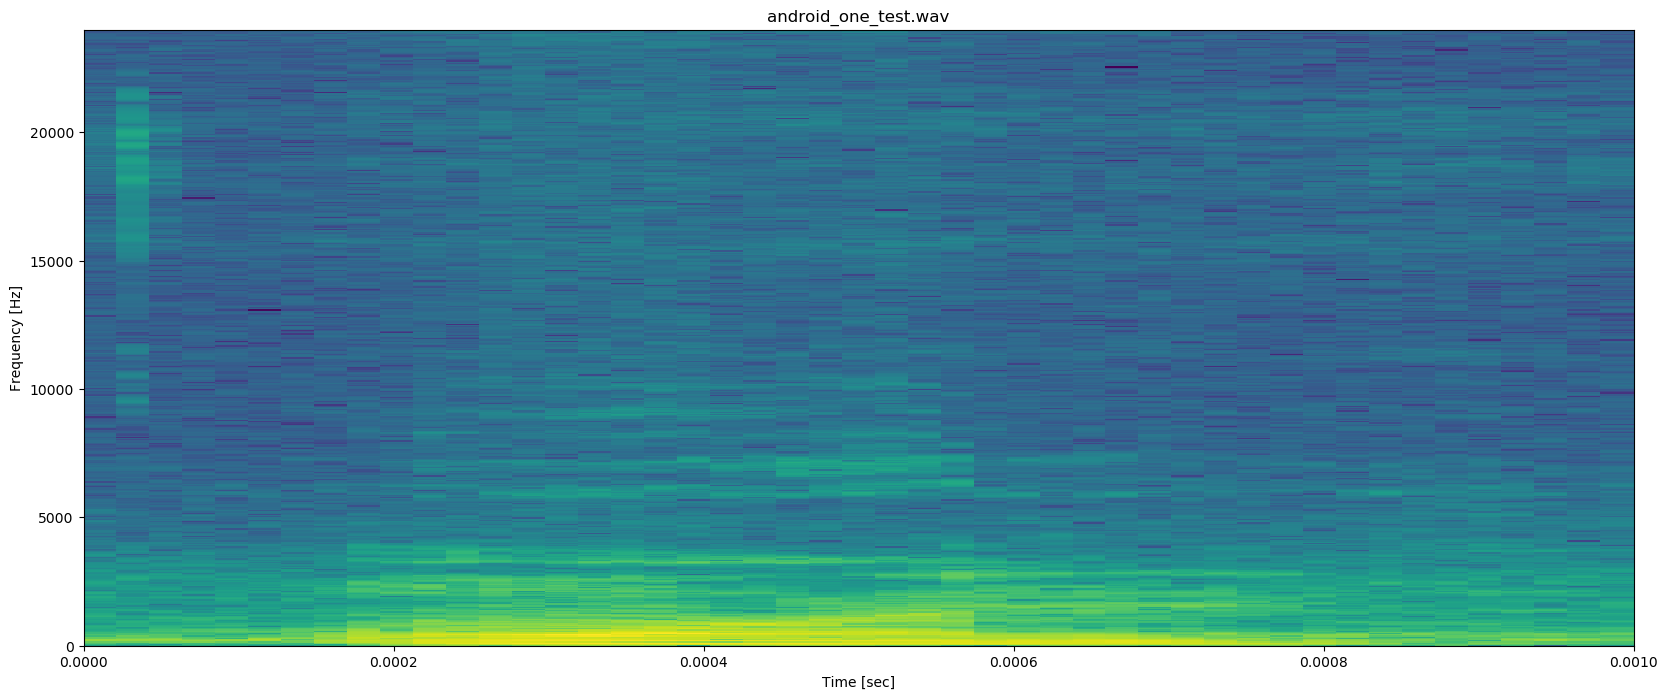

In [7]:
first_frame = first_frame - FRAME_SETBACK
last_frame = (first_frame + NUM_COLS) if ((first_frame + NUM_COLS) < result.shape[1]) else result.shape[1]-1
# altering the STFT
segmented_result = np.zeros((NUM_ROWS, NUM_COLS))
for row in range(NUM_ROWS):
    for col in range(NUM_COLS):
        curr_frame = first_frame + col
        if curr_frame >= result.shape[1]:
            break
        segmented_result[row,col] = result[row, curr_frame]

# altering the data
segmented_data = data[first_frame*step:last_frame*step]

t_stft = np.linspace(0, NUM_COLS / Fs, NUM_COLS)
plt.figure(figsize=(20,8))
plt.pcolormesh(t_stft, f, segmented_result)
plt.title(song_file)
plt.axis('tight')
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
Audio(segmented_data, rate=Fs)

#### Saving Newly Trimmed Data

The code below just shows how to save the newly trimmed audio file and reloading the file is as before.

In [8]:
write("SimplePitchDetectionAudioOut.wav", rate = Fs, data=data[(first_frame-FRAME_SETBACK)*step:].astype(np.int16))
test_fs, test_data = read("SimplePitchDetectionAudioOut.wav")
Audio(test_data, rate=test_fs)

#### Error Checking

Below I am doing a check that performing this pitch detection on the entire AudioMNIST set doesn't create an error, otherwise additional cases will have to be thought through. The only potential case is where no pitch was detected, thus we cannot grab a 'first_frame'. In this scenario, it may suffice to not bother trimming the data and hope that the voiced content resides near the beginning of the audio data. 

In [9]:
# Testing to see if any errors are generated

for i in range(60):
    digit = i + 1
    if digit < 10:
        digit = '0'+str(digit)
    else:
        digit = str(digit)
    curr_audios = os.listdir(curr_dir + '/' + digit)
    for audio_name in curr_audios:

        Fs, data = read(curr_dir + '/' + digit + '/' + audio_name)
        num_samples = len(data)

        noverlap = int(FRAME_SIZE / 2)
        step = FRAME_SIZE - noverlap
        numFrames = ceil(num_samples / step)
        while ((numFrames - 1)*step + (FRAME_SIZE - 1) >= num_samples):
            numFrames -= 1

        # numFrames = int(len(data) / FRAME_SIZE)
        framesVoiced = np.zeros(numFrames)
        t = np.linspace(0, len(data)/Fs, numFrames)

        for i in range(numFrames):
            frame = data[i * step : (i + 1) * step]
            framesVoiced[i] = ece420ProcessFrame(frame.astype(float), 100e4)

        first_frame = np.argwhere(framesVoiced > 0)[0,0] # checking to see if this causes an error where no first_frame is detected
        first_frame = first_frame - FRAME_SETBACK if (first_frame > 0) else 0 # if including the setback results in a negative index, just make the first index 0

#### Data Trimming
This code below is only intended to trim my own voice files and save them to a folder

In [47]:
read_dir = os.getcwd() + '/' + 'raw_voice_files'
write_dir = os.getcwd() + '/' + 'trimmed_voice_files'

raw_file_titles = os.listdir(read_dir)
raw_file_titles.sort()
trimmed_file_data = []

label_counter = 0
for n in range(len(raw_file_titles)):
    raw_file = raw_file_titles[n]
    Fs, data = read(read_dir + '/' + raw_file)

    if (n % 60 == 0) and n != 0:
        label_counter += 1

    num_samples = len(data)
    # print("len of data: {}".format(num_samples))

    noverlap = int(FRAME_SIZE / 2)
    step = FRAME_SIZE - noverlap
    numFrames = ceil(num_samples / step)
    while ((numFrames - 1)*step + (FRAME_SIZE - 1) >= num_samples):
        numFrames -= 1

    framesVoiced = np.zeros(numFrames)
    # t = np.linspace(0, len(data)/Fs, numFrames)

    for i in range(numFrames):
        frame = data[i * step : (i + 1) * step]
        framesVoiced[i] = ece420ProcessFrame(frame.astype(float))

    first_frame = np.argwhere(framesVoiced > 0)[0,0]

    first_frame = first_frame - FRAME_SETBACK
    last_frame = (first_frame + NUM_COLS) if ((first_frame + NUM_COLS) < result.shape[1]) else result.shape[1]-1

    # altering the data
    segmented_data = data[first_frame*step:last_frame*step]
    trimmed_file_data.append((segmented_data, raw_file))
    # write("SimplePitchDetectionAudioOut.wav", rate = Fs, data=data[(first_frame-FRAME_SETBACK)*step:].astype(np.int16))
    write(write_dir + '/' + '{}_{}_data.wav'.format(label_counter, n%60), rate = Fs, data=segmented_data.astype(np.int16))

/tmp/ipykernel_382/3194114125.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = read(read_dir + '/' + raw_file)


In [48]:
# playing some of the files
Audio(trimmed_file_data[500][0], rate=Fs)

## Downsamplilng and Filtering

If pitch detection is being used for the purpose of trimming samples, but the sampled data with will downsampled, it is better to downsample first before trimming. This is because the frame sizes will be different (due to downsampling), and these frames may be necessary for the STFT for example. The rest of this notebook will be an example of filtering, downsampling, pitch detection, and trimming of audio data. 

In [25]:
def createButter(N, Wn, fs):
    num, den = signal.butter(N, Wn, btype='low', analog=False, output='ba', fs=fs)
    return np.array([num[i]/den[i] for i in range(len(num))])

def createFIR(num_taps, cut_off, fs):
    return signal.firwin(num_taps, cut_off, fs=fs)

def displayFIR(filt):
    coef_str = "{" 
    for val in filt: 
        coef_str += str(val) + ", " 
    coef_str = coef_str[:-2] 
    coef_str += "};" 
    print("FIR a Coefficients")
    print(coef_str) 

def applyFIR(samples, filt):
    circBuf = np.zeros(len(filt))
    circBufIdx = 0
    filteredSamples = np.zeros(len(samples))
    num_taps = len(filt)

    for i in range(len(samples)):
        circBuf[circBufIdx] = samples[i]
        curr_val = 0

        for n in range(num_taps):
            curr_val += filt[n] * circBuf[ (((circBufIdx - n) % num_taps) + num_taps) % num_taps]

        filteredSamples[i] = curr_val 
        circBufIdx = (circBufIdx + 1) % num_taps

    return filteredSamples

In [26]:
song_file = 'android_one_test.wav'
Fs, data = read(song_file)
print("Sampling Rate: {}".format(Fs))
print("Data shape: {}".format(data.shape))
Audio(data, rate=Fs)

Sampling Rate: 48000
Data shape: (255360,)


The block below applies a FIR filter with 51 taps at a cut off frequency of 3500 Hz. The purpose of this is because the frequency is being downsampled from 48 KHz down to 8 KHz. Before downsampling to 8 KHz, we wish to cut off frequencies at 4 Khz and higher to prevent aliasing due to Nyquist. Rather than trying to use an even larger number of taps with a cut off frequency near 4 KHz, 3.5 KHz suffices since the human voice cannot reach frequencies in this range anyways. After filtering, we can finally downsample and replay the audio. You will notice the quality diminish, but besides that, the audio content is still the same. 

In [27]:
sig = soundDataToFloat(data)

filt = createFIR(51, 3500, fs=Fs)
filtered_sig = applyFIR(sig, filt)

filtered_sig = np.array([filtered_sig[i] for i in range(0, len(filtered_sig), 6)])
Fs = 8000

print("Sampling Rate: {}".format(Fs))
Audio(filtered_sig, rate=Fs)

Sampling Rate: 8000


Now we can apply data trimming based of pitch detection. For my purposes, I want frame windows of 20-30 ms, with 50% overlap. With a new sampling rate of 8 KHz, I will opt to use frame windows of size 256 (power of 2 for compability with the STFT) which will get me a window size of around 30 ms, and an overlap of 15 ms (50% overlap). 

In [28]:
curr_dir = os.getcwd() + '/' + 'AudioMNIST/data'
# 100e4 for AudioMNIST data set
# for android tablet
# Parameters used on tablet 
VOICED_THRESHOLD = 20000000
FRAME_SETBACK = 2
FS = 48000
DOWN_SAMPLED_FS = 8000
NFFT = 256
NOVERLAP = -1
NFILT = 40
NUM_CEPS = 13
NN_DATA_COLS = 28
NN_DATA_ROWS = 12
PREEMPHASIS_B = 0.97
PIXEL_WIDTH = 400
PIXEL_HEIGHT = 300

len of data: 42560
Num frames: 331
Shape of STFT: (129, 331)
Number of Energy Spectrum Frames: 331
Len f: 129
Len t_stft: 331
First idx 43 at time 0.6932121212121213
Last idx 70 at time 1.1284848484848486


/tmp/ipykernel_12940/4084300420.py:53: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(t, framesVoiced)


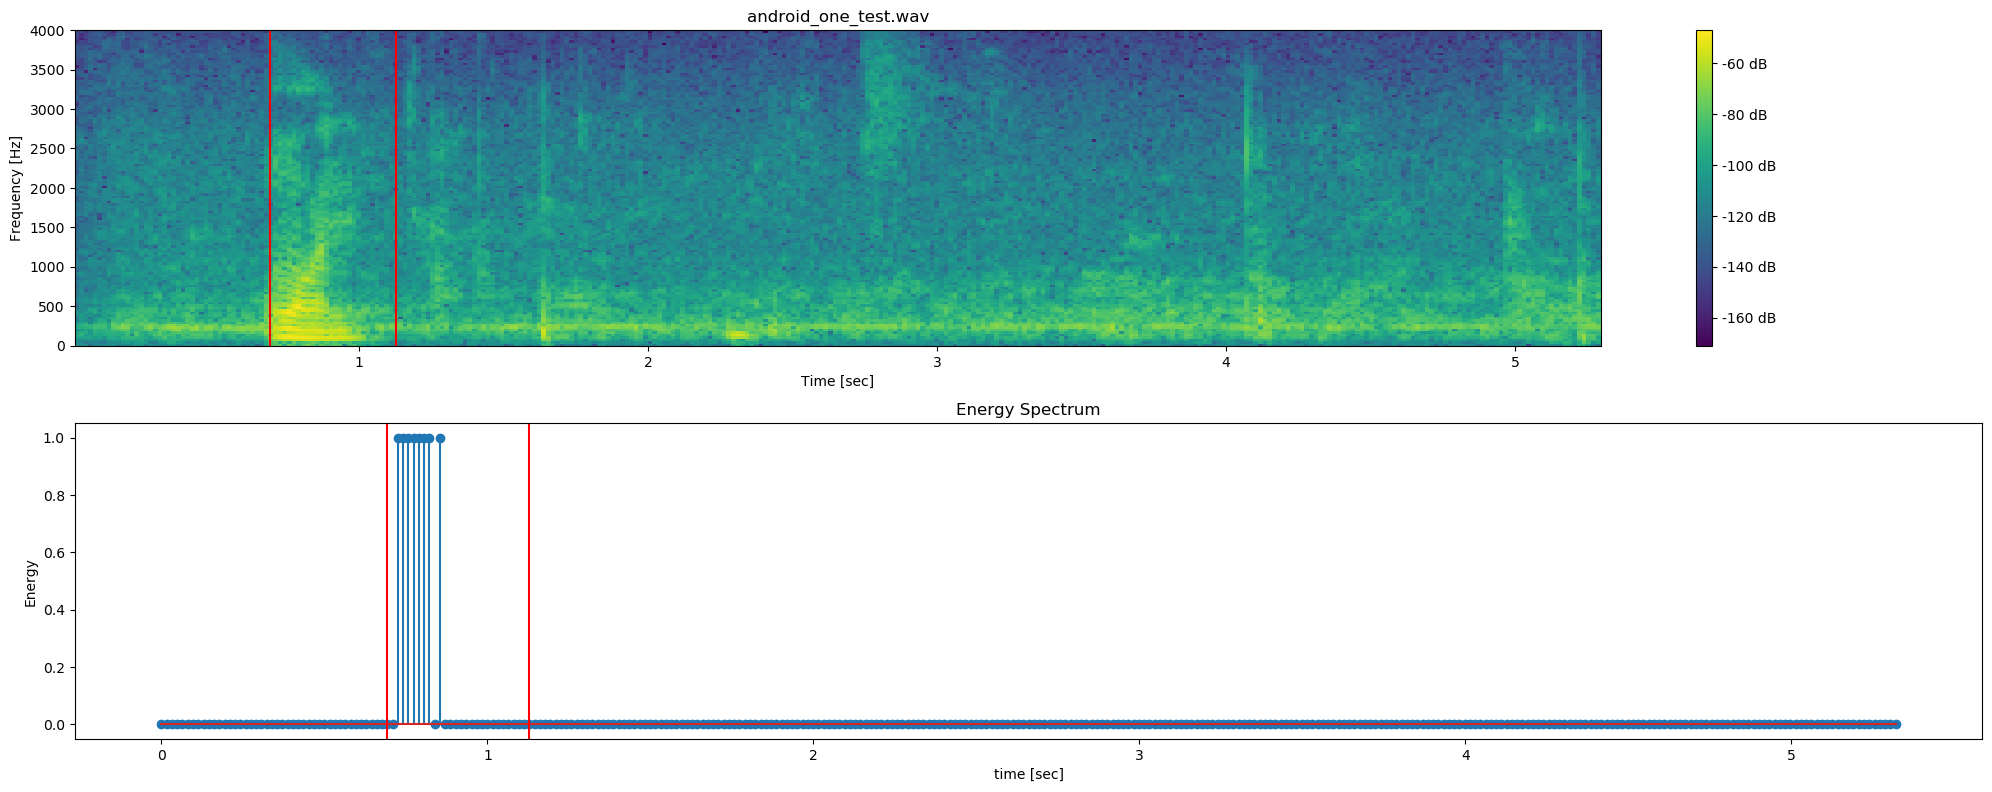

In [29]:
num_samples = len(filtered_sig)
print("len of data: {}".format(num_samples))

""" calculating the number of frames can be created with the given parameters """
noverlap = int(NFFT / 2)
step = NFFT - noverlap
numFrames = ceil(num_samples / step)
while ((numFrames - 1)*step + (NFFT - 1) >= num_samples):
    numFrames -= 1

""" checking which frames are voiced according to the preset threshold """
framesVoiced = np.zeros(numFrames)
t = np.linspace(0, len(filtered_sig)/DOWN_SAMPLED_FS, numFrames)

print("Num frames: {}".format(numFrames))

for i in range(numFrames):
    frame = filtered_sig[i * step : (i + 1) * step]
    framesVoiced[i] = ece420ProcessFrame(soundDataToInt16(frame), threshold=THRESHOLD)


""" conducting a STFT of the filtered_sig with the same frame size to show a comparision of the visualized sound and its energy spectrum """
f, t_stft, result = signal.stft(filtered_sig, fs=DOWN_SAMPLED_FS, window='hann', nperseg=NFFT, nfft=NFFT, noverlap=None, detrend=False, return_onesided=True, boundary=None, padded=False, axis=-1, scaling='psd')
result = 20*np.log10(np.abs(result))

""" printing some parameters """
print("Shape of STFT: {}".format(result.shape))
print("Number of Energy Spectrum Frames: {}".format(numFrames))
print("Len f: {}".format(len(f)))
print("Len t_stft: {}".format(len(t_stft)))

""" getting first frame that meets the threshold """
first_idx = np.argwhere(framesVoiced > 0.5)[0][0] - FRAME_SETBACK
first_idx_t = t[first_idx]
last_idx = first_idx + NN_DATA_COLS - 1
last_idx_t = t[last_idx]
print("First idx {} at time {}".format(first_idx, first_idx_t))
print("Last idx {} at time {}".format(last_idx, last_idx_t))

""" Finally plotting the results """
fig = plt.figure(figsize=(20,8))
plt.subplot(211)
plt.pcolormesh(t_stft, f, result)
plt.title(song_file)
plt.axis('tight')
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.axvline(x=first_idx_t, color='red')
plt.axvline(x=last_idx_t, color='red')
plt.colorbar(format="%+2.f dB") # uncomment to interpret dB content, but leave out for side by side comparison 

plt.subplot(212)
plt.stem(t, framesVoiced)
plt.title("Energy Spectrum")
plt.xlabel("time [sec]")
plt.ylabel("Energy")
plt.axvline(x=first_idx_t, color='red')
plt.axvline(x=last_idx_t, color='red')

fig.tight_layout(pad=1.0)

In [30]:
""" now trimming the data """

# make sure the data is in bounds
if first_idx < 0:
    first_idx = 0
    last_idx = NN_DATA_COLS - 1

# trim and play the audio
trimmed_filtered_sig = filtered_sig[first_idx*step : (last_idx + 1)*step]
Audio(trimmed_filtered_sig, rate=DOWN_SAMPLED_FS)

Finally this method will be applied to all the raw voice files.

In [31]:
read_dir = os.getcwd() + '/' + 'raw_voice_files'
write_dir = os.getcwd() + '/' + 'trimmed_filtered_voice_files_int16'

speakers = os.listdir(read_dir)
trimmed_file_data = []

filt = createFIR(51, 3500, fs=FS)

for speaker in speakers:

    speaker_read_dir = read_dir + '/' + speaker
    speaker_write_dir = write_dir + '/' + speaker
    label_titles = os.listdir(speaker_read_dir)

    for label in label_titles:

        label_read_dir = speaker_read_dir + '/' + label
        raw_file_titles = os.listdir(label_read_dir)
        raw_file_titles.sort()

        label_write_dir = speaker_write_dir + '/' + label

        # create the directory if it does not exist 
        if not os.path.exists(label_write_dir):
            os.makedirs(label_write_dir)

        for n in range(len(raw_file_titles)):
            raw_file = raw_file_titles[n]
            Fs, data = read(label_read_dir + '/' + raw_file)

            num_samples = len(data)

            # filtering the data 
            sig = soundDataToFloat(data)

            filtered_sig = applyFIR(sig, filt)

            # downsampling
            filtered_sig = np.array([filtered_sig[i] for i in range(0, len(filtered_sig), 6)])

            # trimming the samples
            filtered_sig = trimSamples(filtered_sig, NN_DATA_COLS, NFFT, NOVERLAP, THRESHOLD, FRAME_SETBACK)
            
            trimmed_file_data.append((filtered_sig, raw_file))
            write(label_write_dir + '/' + '{}_{}_data.wav'.format(label, n%60), rate = DOWN_SAMPLED_FS, data=soundDataToInt16(filtered_sig))

KeyboardInterrupt: 